In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms, datasets


from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

from torchinfo import summary
from torchmetrics.functional.classification import multiclass_accuracy

import numpy as np
import matplotlib.pyplot as plt

In [38]:
### Resizing
preprocessing = transforms.Compose(transforms=[
    transforms.Resize((50, 50)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [39]:
## ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cpu  Device: cpu


## 이미지 데이터셋

In [40]:
from torchvision.datasets import ImageFolder

In [41]:
img_root = './yelim/test'
imgDS = ImageFolder(root=img_root, transform=preprocessing)

In [42]:
imgDS.classes, imgDS.class_to_idx, imgDS.imgs

(['chihuahua', 'muffin'],
 {'chihuahua': 0, 'muffin': 1},
 [('./yelim/test\\chihuahua\\img_0_1071.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1074.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1082.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1087.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_11.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1107.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1110.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1112.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1117.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1122.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1133.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1139.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1150.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1151.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1154.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1159.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1161.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1169.jpg', 0),
  ('./yelim/test\\chihuahua\\img_0_1172.jpg'

In [43]:
from torch.utils.data import DataLoader
imgDL = DataLoader(imgDS)

for (img,label) in imgDL:
    print(img.shape, label.shape, label)
    break

torch.Size([1, 3, 50, 50]) torch.Size([1]) tensor([0])


# 데이터 준비

In [44]:
BATCH_SIZE =32
EPOCHS = 10

In [45]:
train_dataset = datasets.ImageFolder(root=img_root, transform=preprocessing)

test_dataset = datasets.ImageFolder(root=img_root, transform=preprocessing)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [46]:
### ==> 데이터 확인하기 (1)
### ==> x_train : torch.size([32,3,50,50])[배치사이즈, 채널, 높이, 너비]
### ==> y_train : torch.size([72])[배치사이즈] 즉 72개 이미지에 대한 라벨
for (X_train,y_train) in train_loader:
    print('X_train:',X_train.size(), 'type:',X_train.type())
    print('y_train:',y_train.size(), 'type:',y_train.type())
    break
    

X_train: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


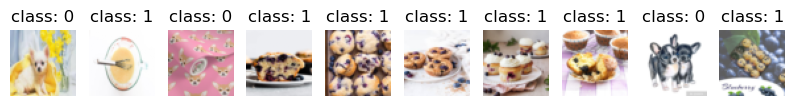

In [47]:
### ==> 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))

for i in range(10):
    plt.subplot(1,10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1,2,0)))
    plt.title('class: ' + str(y_train[i].item()))

- 모델 설계

In [73]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels =8, kernel_size = 3, padding =1)
        self.conv2 = nn.Conv2d(in_channels =8, out_channels = 16, kernel_size = 3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(12*12*16,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,2)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 12*12*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
        

- 학습 준비

In [74]:
### ===> Optimizer, Objective Function 설정
model = CNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


In [75]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 1184
    Root location: ./yelim/test
    StandardTransform
Transform: Compose(
               Resize(size=(50, 50), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

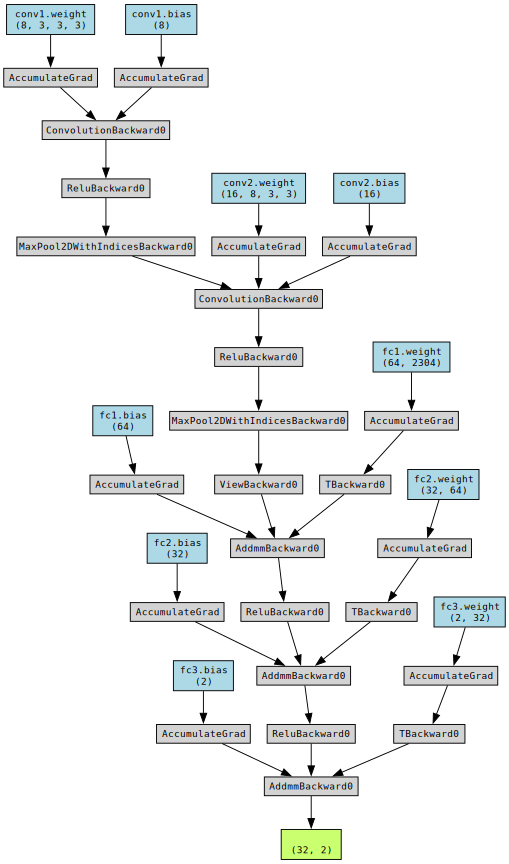

In [76]:
from torchviz import make_dot

#x=torch.randn(1,3,32,32).to(DEVICE)
#y=model(x)

make_dot(model(X_train),params=dict(model.named_parameters()))

In [77]:
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        print(image.shape, label.shape)
        optimizer.zero_grad()
        output = model(image)
        print(output)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}')

In [78]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader)
    return test_loss, test_accuracy

In [79]:
### ===> CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for epoch in range(1, EPOCHS + 1):
    
    train(epoch, model, train_loader, optimizer, log_interval=10)
    #test_loss,test_accuracy = evaluate(model, test_loader)
    
    #print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

torch.Size([32, 3, 50, 50]) torch.Size([32])
tensor([[-0.0973,  0.0852],
        [-0.0906,  0.0790],
        [-0.0880,  0.0852],
        [-0.0965,  0.0849],
        [-0.0954,  0.0873],
        [-0.0926,  0.0775],
        [-0.0905,  0.0792],
        [-0.0916,  0.0824],
        [-0.0911,  0.0801],
        [-0.0933,  0.0824],
        [-0.0976,  0.0812],
        [-0.0885,  0.0749],
        [-0.0930,  0.0823],
        [-0.0955,  0.0848],
        [-0.0876,  0.0807],
        [-0.0927,  0.0794],
        [-0.0913,  0.0846],
        [-0.0942,  0.0817],
        [-0.0931,  0.0867],
        [-0.0930,  0.0783],
        [-0.0976,  0.0829],
        [-0.0925,  0.0823],
        [-0.0885,  0.0798],
        [-0.0931,  0.0854],
        [-0.0948,  0.0841],
        [-0.0916,  0.0833],
        [-0.0916,  0.0830],
        [-0.0986,  0.0880],
        [-0.0936,  0.0869],
        [-0.0925,  0.0867],
        [-0.0944,  0.0826],
        [-0.0966,  0.0873]], grad_fn=<AddmmBackward0>)
Train Epoch: 1 [0]	Train Loss: 0